# Results visualization

In [128]:
import pandas as pd
import numpy as np
import os


In [129]:
ls results

car_final.csv     iris_sorct.csv           seeds_data_results.csv
car_results.csv   new_thyroid_final.csv    seeds_data_sorct.csv
car_sorct.csv     new_thyroid_results.csv  splice_results.csv
iris_final.csv    new_thyroid_sorct.csv    splice_sorct.csv
iris_results.csv  seeds_data_final.csv


In [130]:
res_path = "results"
names = ["car", "iris", "seeds_data", "new_thyroid", "splice"]
path = os.path.join(res_path, "{}_results.csv".format(name))
df = pd.read_csv(path, sep=" ", index_col=0)
rob = pd.read_csv("results/iris_sorct.csv", sep=" ", index_col=0)
rob

,Time_0,Iterations_0,Score_0,Time_1,Iterations_1,Score_1,Time_2,Iterations_2,Score_2,Time_3,Iterations_3,Score_3,Time_4,Iterations_4,Score_4
SORCT,4.531772,312.0,1.0,12.937899,810.0,0.966667,9.507198,539.0,0.966667,0.189414,7.0,0.266667,11.403092,828.0,0.966667


In [148]:
IGNORE_HLR_TIME = True
N_FOLDS = 5
dfs = []
for file_index in range(len(names)):
    name = names[file_index]
    path = os.path.join(res_path, "{}_results.csv".format(name))
    df = pd.read_csv(path, sep=" ", index_col=0)
    sorct_df = pd.read_csv(os.path.join(res_path,"{}_sorct.csv".format(name)), sep=" ", index_col=0)
    if -1 in df or -2 in df or -3 in df:
        print("Some folds were not computed")
    res_index = df.index
    res_index = res_index.append(sorct_df.index)
    result_df = pd.DataFrame(index=res_index)
    
    
    for cl_name in res_index:
        
        
        n_invalid = 0
        n_invalid_sorct = 0
        time = 0
        hlr_time = 0
        iters = 0
        hlr_score = 0
        sorct_score = 0
        hs = 0
        cp = 0
        # sorct no init values
        no_init_time = 0
        no_init_iters = 0
        no_init_score = 0
        for fold_index in range(N_FOLDS):
            if cl_name != "SORCT":
                if df.loc[cl_name,"Time_{}".format(fold_index)] < 0:
                    print( df.loc[cl_name,"Time_{}".format(fold_index)])
                    n_invalid += 1
                    print(df.loc[cl_name,"Time_{}".format(fold_index)])
                else:
                    time += df.loc[cl_name,"Time_{}".format(fold_index)]
                    if not IGNORE_HLR_TIME:
                        hlr_time += df.loc[cl_name, "HLR_Time_{}".format(fold_index)]
                    iters += df.loc[cl_name, "Iterations_{}".format(fold_index)]
                    hlr_score += df.loc[cl_name, "HLR_Score_{}".format(fold_index)]
                    sorct_score += df.loc[cl_name, "SORCT_Score_{}".format(fold_index)]
                    hs += df.loc[cl_name, "Homogeneity_{}".format(fold_index)]
                    cp += df.loc[cl_name, "Completeness_{}".format(fold_index)]
            # else sorct no init
            else:
                if  sorct_df.loc["SORCT", "Time_{}".format(fold_index) ] < 0:
                    n_invalid_sorct +=1
                else:
                    no_init_time += sorct_df.loc["SORCT", "Time_{}".format(fold_index) ]
                    no_init_iters +=  sorct_df.loc["SORCT", "Iterations_{}".format(fold_index) ]
                    no_init_score +=  sorct_df.loc["SORCT", "Score_{}".format(fold_index) ]
        if cl_name != "SORCT":
            real_folds = N_FOLDS - n_invalid
            time = time / real_folds
            hlr_time = hlr_time / real_folds
            iters = iters / real_folds
            hlr_score = hlr_score / real_folds
            sorct_score = sorct_score / real_folds
            hs = hs / real_folds
            cp = cp / real_folds
            result_df.loc[cl_name, "Time"] = time
            if not IGNORE_HLR_TIME:
                result_df.loc[cl_name, "HLR_Time"] = hlr_time
            result_df.loc[cl_name, "Iterations"] = iters
            result_df.loc[cl_name, "HLR_Score"] = hlr_score
            result_df.loc[cl_name, "SORCT_Score"] = sorct_score
            result_df.loc[cl_name, "Homogeneity"] = hs
            result_df.loc[cl_name, "Completeness"] = cp
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid 
        else:
            n_folds_reals = N_FOLDS - n_invalid_sorct
            result_df.loc[cl_name, "Invalid Folds"] = n_invalid_sorct 
            result_df.loc[cl_name, "Time"] = no_init_time / n_folds_reals
            result_df.loc[cl_name, "Iterations"] = no_init_iters / n_folds_reals
            result_df.loc[cl_name, "SORCT_Score"] = no_init_score / n_folds_reals

    #result_df["Invalid Folds"] = result_df["Invalid Folds"].astype("int32")
    dfs.append(result_df)
    result_df.to_csv(os.path.join(res_path, "{}_final.csv".format(name)), float_format='%.2f')
    
        
    

-3.0
-3.0
-1.0
-1.0
-3.0
-3.0
-3.0
-3.0


In [132]:
ls results/

car_final.csv     iris_sorct.csv           seeds_data_results.csv
car_results.csv   new_thyroid_final.csv    seeds_data_sorct.csv
car_sorct.csv     new_thyroid_results.csv  splice_final.csv
iris_final.csv    new_thyroid_sorct.csv    splice_results.csv
iris_results.csv  seeds_data_final.csv     splice_sorct.csv


In [133]:
dfs[-1]

,Time,Iterations,HLR_Score,SORCT_Score,Homogeneity,Completeness,Invalid Folds
kmeans,349.290205,241.2,0.89586,0.849453,0.319561,0.238326,0.0
Agglomerative_sigle,699.181333,413.2,0.89586,0.850068,0.001493,0.079618,0.0
birch,396.772047,243.4,0.89586,0.788624,0.213518,0.161429,0.0
True_labels,1282.875272,397.6,0.89586,0.840043,1.000000,1.000000,0.0
SORCT,466.232489,282.8,NaN,0.856978,NaN,NaN,0.0


In [146]:
aa =pd.read_csv("datasets/splice.csv", sep=";")

In [147]:
aa.shape

(1594, 187)

(array([70.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0., 70.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

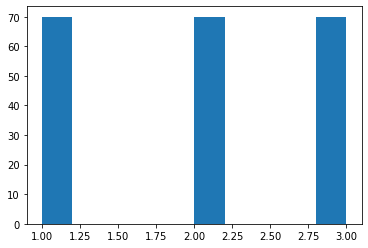

In [145]:
import matplotlib.pyplot as plt
plt.hist(aa[list(aa.columns)[-1]])